# Purpose

This notebook will use some basic ML code to attempt to identify the driver corresponding to a randomly selected telemetry trace.  Currently this is extremely early stages, so we will see how well that works!

# Method

Telemetry traces will be accessed for a given track using the fastf1 package.  These will be used to train the NN.  Finally, I will test the data using data not used in the training data. 

I am considering testing this in a few ways:

- Train on 1 race, test on same race
- Train on 1 race, test on different race
- Train on all races, test on any race
- Train on rualifying, test on race

# Purpose

This notebook will use some basic ML code to attempt to identify the driver corresponding to a randomly selected telemetry trace.  Currently this is extremely early stages, so we will see how well that works!

# Method

Telemetry traces will be accessed for a given track using the fastf1 package.  These will be used to train the NN.  Finally, I will test the data using data not used in the training data. 

I am considering testing this in a few ways:

- Train on 1 race, test on same race
- Train on 1 race, test on different race
- Train on all races, test on any race
- Train on rualifying, test on race

In [1]:
import os
import sys

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import cm
%matplotlib widget

import fastf1
import fastf1.plotting
fastf1.Cache.enable_cache(os.environ['f1_cache'])  

import tensorflow as tf
from tensorflow import keras
import keras_tuner
from keras import optimizers

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

sys.path.append(os.environ['f1_install'])
from tools.fastf1_tools import loadTelemForYear, loadTelemForEvent

plt.ion()

# https://www.youtube.com/watch?v=qFJeN9V1ZsI&ab_channel=freeCodeCamp.org
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print('Number of GPUs Available: {}'.format(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Set seed for reproducable testing
np.random.seed(0)

Number of GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:


# Get speed traces for Max in Abu Dhabi 2022 GP
schedule = fastf1.get_event_schedule(year=2022, include_testing=False)
event = schedule.get_event_by_round(1)
session = event.get_session('R')
session.load()
driver_info = fastf1.api.driver_info(session.api_path)
all_drivers = np.asarray([d['Tla'] for i, d in driver_info.items()])

path = os.path.join(os.environ['f1_install'], 'dataframes')
telem_param = 'Speed'

refined_laps = loadTelemForEvent(event, path=path, telem_param=telem_param) # Formatted laps generated by ml/save_lap_telemetry.py


# Simplify the problem down to a handful of drivers first
choose_drivers = ['VER', 'HAM', 'LEC']

columns = refined_laps.columns[[np.isin(c.split('_')[0], choose_drivers) for c in refined_laps.columns]]
refined_laps = refined_laps[columns]
all_drivers = choose_drivers

print(refined_laps.head())


core           INFO 	Loading data for Bahrain Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '55', '44', '63', '20', '77', '31', '22', '14', '24', '47', '18', '23', '3', '4', '6', '27', '11', '1', '10']
api            INFO 	Using cached data for driver_info


Loading C:\Users\dsouthall\projects\f1\f1_djsouthall\dataframes\Speed_Bahrain_Grand_Prix_2022.pkl
                             LEC_2       LEC_3       LEC_4       LEC_5  \
0 days 00:00:00         276.500000  276.500000  276.500000  276.000000   
0 days 00:00:00.100000  276.875000  277.625000  276.875000  276.500000   
0 days 00:00:00.200000  277.480769  278.461538  277.653846  277.076923   
0 days 00:00:00.300000  278.168750  279.275000  278.562500  277.700000   
0 days 00:00:00.400000  278.892562  280.095041  279.190083  278.570248   

                             LEC_6       LEC_7       LEC_8       LEC_9  \
0 days 00:00:00         277.000000  277.000000  276.000000  275.000000   
0 days 00:00:00.100000  277.750000  277.750000  276.375000  275.750000   
0 days 00:00:00.200000  278.615385  278.269231  277.500000  276.615385   
0 days 00:00:00.300000  279.325000  278.762500  278.512500  277.325000   
0 days 00:00:00.400000  280.000000  279.423554  279.508264  278.000000   

            

Here we randomize the lap order.

In [3]:

randomized_indices = np.random.choice(range(len(refined_laps.columns)), len(refined_laps.columns))
refined_laps = refined_laps.iloc[:, randomized_indices]# Shuffled randomly
refined_laps = refined_laps.dropna() # Will cut off laps beyond shortest lap of the season.  But is a quick way to normalize data. 

print(refined_laps.head())

                             HAM_2      VER_32      HAM_25      VER_16  \
0 days 00:00:00         279.000000  280.750000  275.000000  279.000000   
0 days 00:00:00.100000  279.750000  281.562500  276.500000  279.750000   
0 days 00:00:00.200000  279.923077  282.500000  276.846154  280.615385   
0 days 00:00:00.300000  279.975000  283.512500  277.456250  281.550000   
0 days 00:00:00.400000  280.661157  284.173554  278.154959  282.185950   

                            LEC_11      LEC_25      LEC_42      HAM_54  \
0 days 00:00:00         277.000000  279.500000  282.666667  289.000000   
0 days 00:00:00.100000  277.375000  280.062500  282.979167  289.375000   
0 days 00:00:00.200000  277.807692  280.711538  283.339744  289.807692   
0 days 00:00:00.300000  278.275000  281.243750  283.785417  291.625000   
0 days 00:00:00.400000  278.927686  281.750000  284.263774  292.880165   

                            HAM_30      HAM_55  ...      HAM_32      LEC_23  \
0 days 00:00:00         279.500

Next we quickly plot the laps, helpful for checking the data is sensible.  

Text(0.5, 1.0, 'Driver Lap Times For Loaded Session\n(Normal Conditions)')

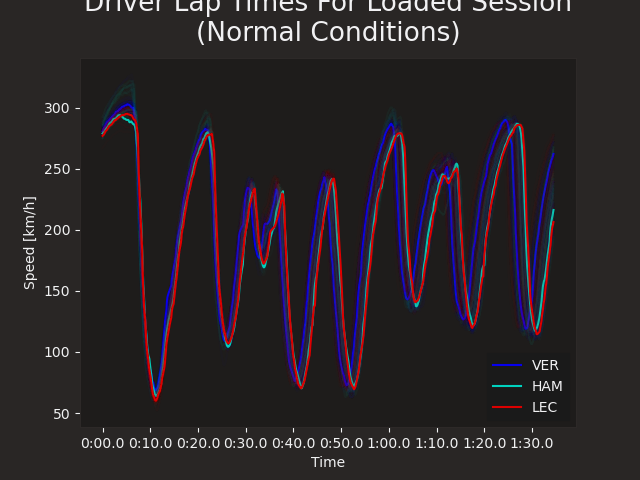

In [4]:
# Quickly plot laps
plt.figure()

for driver in all_drivers:
    driver_laps = refined_laps.loc[:, refined_laps.columns.str.match('{}*'.format(driver))]
    laptimes = driver_laps.notna()[::-1].idxmax()
    min_lap = laptimes.argmin()
    max_lap = laptimes.argmax()
    for i, (lap_name, lap) in enumerate(driver_laps.iteritems()):
        plt.plot(lap, alpha=1.0 if i == min_lap else 1.0/len(driver_laps.columns), c=fastf1.plotting.driver_color(driver), label=driver if i == min_lap else None)

leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.ylabel('Speed [km/h]')
plt.xlabel('Time')
plt.title('Driver Lap Times For Loaded Session\n(Normal Conditions)')

### Status
At this point we have obtained a set of consistently formatted (sampled equally in time and of equal length) speed traces.

# Machine Learning Descrimination

Below is where I begin playing with actual ML code.

## Preparing Data
The data must be represented as normalized arrays, with features like driver id's being integers.  This is done below.


In [5]:
# Get numpy array where each row is lap, and obtain labels. 
np_laps = refined_laps.to_numpy().T #Will cut off laps longer than shortest lap in the calander.
labels = np.asarray([c.split('_')[0] for c in refined_laps.columns]) # np.asarray([np.where(all_drivers == c.split('_')[0])[0][0] for c in refined_laps.columns]) # Each driver associated with an integer.

training_percent = 0.8

training_n = int(training_percent*len(refined_laps.columns))
training_indices = np.random.choice(range(len(refined_laps.columns)), size=training_n, replace=False)

testing_indices = np.arange(len(refined_laps.columns))[~np.isin(np.arange(len(refined_laps.columns)), training_indices)]

print('Training on {} laps, and testing on {}'.format(len(training_indices), len(testing_indices)))


Training on 105 laps, and testing on 27


In [6]:
# Prepare preprocessing
scaler = keras.layers.Rescaling(scale=1.0/np.nanmax(np_laps))
vectorizer = keras.layers.TextVectorization(output_mode="int")
vectorizer.adapt(labels)
num_classes = len(np.unique(labels))

# Prepare Training Data
training_labels = vectorizer(labels[training_indices])
training_data = scaler(np_laps[training_indices])#tf.convert_to_tensor(np_laps[training_indices])

# # Preparing Testing Data
testing_labels = vectorizer(labels[testing_indices])
testing_data = scaler(np_laps[testing_indices])#tf.convert_to_tensor(np_laps[testing_indices])

# training_data = tf.ragged.constant([i[~np.isnan(i)] for i in np_laps[training_indices]]) # Convert the laps to a ragged tensor, while dropping all NaN values. 
# training_data = scaler(training_data)

# testing_data = tf.ragged.constant([i[~np.isnan(i)] for i in np_laps[testing_indices]]) # Convert the laps to a ragged tensor, while dropping all NaN values. 
# testing_data = scaler(testing_data)

## Preparing Model
Now we start preparing the model.

In [31]:
# I need to understand this layer.  Currently just using code without strong understanding/motivation.

# def make_model(input_shape):

#     inputs = keras.Input(shape=input_shape)

#     x = keras.layers.Rescaling(scale=1.0/400.0)(inputs)

#     x = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(x)
#     x = keras.layers.BatchNormalization()(x)
#     x = keras.layers.ReLU()(x)

#     x = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(x)
#     x = keras.layers.BatchNormalization()(x)
#     x = keras.layers.ReLU()(x)

#     x = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(x)
#     x = keras.layers.BatchNormalization()(x)
#     x = keras.layers.ReLU()(x)

#     x = keras.layers.GlobalAveragePooling1D(data_format='channels_last')(x)

#     outputs = keras.layers.Dense(num_classes, activation="softmax")(x)

#     model = keras.Model(inputs=inputs, outputs=outputs)
#     model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-3), loss=keras.losses.CategoricalCrossentropy())

#     return model

# def make_model(input_shape):
#     inputs = keras.Input(shape=input_shape)
#     x = keras.layers.Rescaling(scale=1.0/400.0)(inputs)

#     x = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(x)
#     x = keras.layers.BatchNormalization()(x)
#     x = keras.layers.ReLU()(x)

#     x = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(x)
#     x = keras.layers.BatchNormalization()(x)
#     x = keras.layers.ReLU()(x)

#     x = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(x)
#     x = keras.layers.BatchNormalization()(x)
#     x = keras.layers.ReLU()(x)

#     x = keras.layers.GlobalAveragePooling1D(data_format='channels_last')(x)

#     outputs = keras.layers.Dense(num_classes, activation="softmax")(x)

#     model = keras.Model(inputs=inputs, outputs=outputs)
#     model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-3), loss=keras.losses.CategoricalCrossentropy())

#     return model

model = keras.models.Sequential([
    keras.layers.Dense(units=200, activation='relu', input_shape=(training_data.shape[1],)),
    keras.layers.Dense(units=32, activation='relu'),
    keras.layers.Dense(units=16, activation='relu'),
    keras.layers.Dense(units=len(all_drivers), activation='softmax')
    ])

optimizer = optimizers.Adam()#clipvalue=0.5
model.summary()
model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy ",metrics=['accuracy'])#mean_squared_error
# model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-3), loss=keras.losses.CategoricalCrossentropy())
# processed_data = model(training_data)
# print(np.shape(processed_data))
# print(processed_data)
print(training_data.shape)
print((None, training_data.shape[1:][0], 1))
# model = make_model((training_data.shape[1:][0], 1))

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_53 (Dense)            (None, 200)               189400    
                                                                 
 dense_54 (Dense)            (None, 32)                6432      
                                                                 
 dense_55 (Dense)            (None, 16)                528       
                                                                 
 dense_56 (Dense)            (None, 3)                 51        
                                                                 
Total params: 196,411
Trainable params: 196,411
Non-trainable params: 0
_________________________________________________________________
(105, 946)
(None, 946, 1)


## Training Model

In [32]:
# Perform checks on data
assert np.any(np.isnan(training_data)) == False
assert np.any(np.isnan(training_labels)) == False
assert np.any(np.isnan(testing_data)) == False
assert np.any(np.isnan(testing_labels)) == False
assert type(training_data) == type(training_labels)

model.fit(training_data, training_labels, batch_size=100, epochs=1000, verbose=1)

testing_model = model.evaluate(testing_data,testing_labels,verbose=1)

# Changing the accuracy into a percentage
testing_acc = testing_model[1]*100
# Printing the accuracy
print('Test Accuracy - ', testing_acc,'%')

Epoch 1/1000
2/2 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 2/1000
2/2 [==============================] - 0s 6ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 3/1000
2/2 [==============================] - 0s 9ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 4/1000
2/2 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 5/1000
2/2 [==============================] - 0s 8ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 6/1000
2/2 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 7/1000
2/2 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 8/1000
2/2 [==============================] - 0s 9ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 9/1000
2/2 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 10/1000
2/2 [==============================] - 0s 8ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 11/

def_function    WARNING 	6 out of the last 8 calls to <function Model.make_test_function.<locals>.test_function at 0x000001F0102AEA60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 137ms/step - loss: nan - accuracy: 0.0000e+00
Test Accuracy -  0.0 %
